In [1]:
using Distributions
using Random
using DelimitedFiles
using ParticleFilters
using PyPlot
using StatsBase
using Images
using BenchmarkTools
using CUDA
using Serialization

In [2]:
include("./ParallelParticleFilters.jl")
using .ParallelParticleFilters

In [3]:
Threads.nthreads()

4

## Load Data

#### Bathymetry Map (for measurement model)

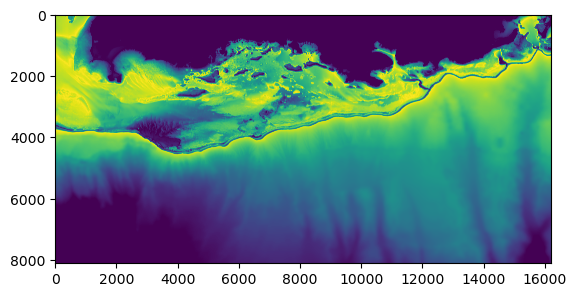

In [4]:
# Open the tiff file
filename = "PuertoRico_SouthWest_Color.tif"
img = load(filename)

function rgb_to_value(rgb_color::RGB{N0f8})
    # Interpolate between blue and red based on the green component
    green_component = green(rgb_color)
    value = 30-30 * (1 - green_component)

    # Return the value
    return value
end

function lookup_depth(x, y, map)
    # In meters
    # column, row (x, y) format. 0, 0 is top left of image    
    
    # Find the pixel with the closest x, y values
    x_idx = argmin(abs.(collect(1:size(map, 2)) .- x))
    y_idx = argmin(abs.(collect(1:size(map, 1)) .- y))
    
    # Look up the pixel value
    pixel_value = map[y_idx, x_idx] 
    
    return pixel_value 
end

# Apply the rgb_to_value function to the image
value_image = map(rgb_to_value, img)

# Display the value image
imshow(value_image)

bathy_map = value_image[1500:2500,6000:8000];

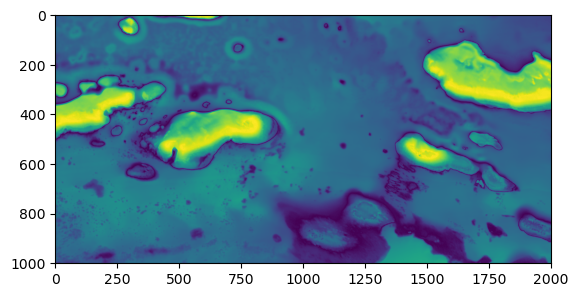

PyObject <matplotlib.image.AxesImage object at 0x00000187C186C820>

In [5]:
imshow(-bathy_map)

## Particle Filter Models
Use closures to create dynamics and measurement models

#### Dynamics Model

In [6]:
function vehicle_dynamics_model(x, u, rng, delta_t; noise=false)
    """
    inputs:
        x: state
        u: control input
    output:
        updated state (same shape as x)
    """
    x_pos, y_pos, θ, v, dθ = x
    in_thruster, in_rudder = u
        
    if noise
        x_step = x_pos + delta_t*v*cos(θ) + randn()*1
        y_step = y_pos + delta_t*v*sin(θ) + randn()*1
        θ_step = θ + delta_t*dθ + randn()*0.002
    else
        # Update position based on state
        x_step = x_pos + delta_t*v*cos(θ)
        y_step = y_pos + delta_t*v*sin(θ)
        θ_step = θ + delta_t*dθ
    end
    # Update velocities based on input
    v_step = v + delta_t*(in_thruster-v)
    dθ_step = dθ + delta_t*in_rudder
    
    return [x_step, y_step, θ_step, v_step, dθ_step]
end

function generate_dynamics_model(delta_t)
    return (x, u, rng) -> vehicle_dynamics_model(x, u, rng, delta_t, noise=true)
end

# dynamics_model = generate_dynamics_model(delta_t)

generate_dynamics_model (generic function with 1 method)

#### Measurement Model

In [7]:
# Measurement Model
# (computes likelihood of measurement, given previous state, action, and current state)
# Note: our measurement only depends on current state
function vehicle_measurement_model(x1, u, x2, y, η, bathy_map, ϵ)
    """
    inputs:
        x1: current state
        u: control input
        x2: next state
        y: measurement
        η: noise amplitude
        bathy_map: bathymetry map
        ε: minimum likelihood
    output:
        likelihood (float)
    """
    
    # State vector: x, y, θ, linear velocity, angular velocity
    x_pos, y_pos, θ, v, dθ = x2
    measured_depth = y
    
    model_depth = lookup_depth(x_pos, y_pos, bathy_map)

    dist = Normal(model_depth, η)
    pdf_value = pdf(dist, measured_depth)
    
    # Ensure all particles have at least small likelihood
    if pdf_value < ϵ
        return ϵ
    end
    
    return pdf_value
end

function generate_measurement_model(η, bathy_map, ϵ)
    return (x1, u, x2, y) -> vehicle_measurement_model(x1, u, x2, y, η, bathy_map, ϵ)
end

# measurement_model = generate_measurement_model(η, bathy_map)

generate_measurement_model (generic function with 1 method)

## Generate Dataset

In [8]:
function generate_random_func()
    n = 5
    a = 0.05
    A = rand(-a:0.01:a, n)
    B = rand(-a:0.01:a, n)
    random_func(t) = sum(A[i]*sin.(B[i]*t) * A[i+1]*cos.(B[i+1]*t) for i in 1:n-1)
    return random_func
end

function generate_data_from_func(ts, func)
    output = similar(ts)
    for (i, t) in enumerate(ts)
        output[i] = func(t)
    end
    return output
end

function simulate_trajectory(ts, in_thruster, in_rudder; start_x=0, start_y=0, start_θ=0, delta_t=0.1)
    xs = similar(ts)
    ys = similar(ts)
    vs = similar(ts)
    θs  = similar(ts)
    dθs = similar(ts)
    
    # Initialize state to 0
    xs[1] = start_x # X position
    ys[1] = start_y # Y position
    vs[1] = 0 # Velocity
    θs[1] = start_θ # Heading
    dθs[1] = 0 # Angular Velocity
    
    for (i, t) in enumerate(ts[1:end-1])
        state = [xs[i], ys[i], θs[i], vs[i], dθs[i]]
        u = [in_thruster[i], in_rudder[i]]
        xs[i+1], ys[i+1], θs[i+1], vs[i+1], dθs[i+1] = 
            vehicle_dynamics_model(state, u, rng, delta_t)
    end
    
    return xs, ys, θs, vs, dθs
end

function simulate_measurements(xs, ys, map, η)
    output = similar(xs)
    
    noise_dist = Normal(0, η)
    
    for (i, (x, y)) in enumerate(zip(xs, ys))
        output[i] = lookup_depth(x, y, map) + rand(noise_dist)
    end
    
    return output
end

simulate_measurements (generic function with 1 method)

#### Preview & Save Generated Trajectory
Note: For consistency in benchmarking, we'll save a couple trajectories and only use those instead of generating random ones for each test.

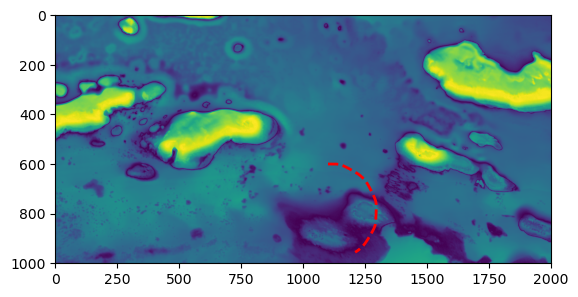

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000187DE5BAB60>

In [9]:
# Start in middle of map
START_X = 1100 
START_Y = 600
START_θ = 0

# For previewing
SIM_TIME = 1000 # s
N_STEPS = 1001

ts = range(0, stop=SIM_TIME, length=N_STEPS)
DELTA_T = ts[2] - ts[1]
rng = MersenneTwister(1)

generated_func = generate_random_func()
in_thruster = 0.5*ones(size(ts))
in_rudder = 0.1*generate_data_from_func(ts, generated_func)

xs, ys, θs, vs, dθs = simulate_trajectory(ts, in_thruster, in_rudder, 
    start_x=START_X, start_y=START_Y, start_θ=START_θ, delta_t=DELTA_T)

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(xs,ys,"r--", lw=2)

In [10]:
# # Save Function to file, if desired
# open("generated_func7.jls", "w") do io
#     serialize(io, generated_func)
# end

#### Dataset Generator Functions

In [11]:
function generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, η)
    ts = range(0, stop=sim_time, length=n_steps)
    delta_t = ts[2] - ts[1]
    
    in_thruster = 0.5*ones(size(ts))
    in_rudder = 0.1*generate_data_from_func(ts, input_func)

    xs, ys, θs, vs, dθs = simulate_trajectory(ts, in_thruster, in_rudder, 
        start_x=start_x, start_y=start_y, start_θ=start_θ, delta_t=delta_t)

    measurements = simulate_measurements(xs, ys, bathy_map, η)
    
    return xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements
end

generate_data (generic function with 1 method)

## ParticleFilters.jl

In [12]:
function compute_initial_particles(n_particles, init_std_pos, init_std_rot, start_x, start_y, start_θ)
    init_particles = Vector{Vector{Float64}}(undef, n_particles)
    
    dist_pos_init = Normal(0, init_std_pos)
    dist_rot_init = Normal(0, init_std_rot)
    
    for i in 1:n_particles
        # Generate sample
        x = start_x + rand(dist_pos_init)
        y = start_y + rand(dist_pos_init)
        θ = start_θ + rand(dist_rot_init)
        init_particles[i] = [x, y, θ, 0, 0]
    end

    return init_particles
end

compute_initial_particles (generic function with 1 method)

In [13]:
function bench_pf(
        n_particles, init_std_pos, init_std_rot, η, bathy_map, ϵ, # Modelling params
        start_x, start_y, start_θ, sim_time, n_steps, input_func, # Dataset params
        num_evals, num_samples, plot=true) # Benchmarking params
    
    delta_t = range(0, stop=sim_time, length=n_steps)[2] - 
              range(0, stop=sim_time, length=n_steps)[1]
    
    dynamics_model = generate_dynamics_model(delta_t)
    measurement_model = generate_measurement_model(η, bathy_map, ϵ)
    
    pf_model = ParticleFilterModel{Vector{Float64}}(dynamics_model, measurement_model)

    fil = BootstrapFilter(pf_model, n_particles) # Takes in model, number of particles

    # construct initial belief
    init_particles = compute_initial_particles(n_particles, 
            init_std_pos, init_std_rot, start_x, start_y, start_θ)
    b0 = ParticleCollection(init_particles)
    
    xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements = 
        generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, η)

    # Plot initial samples
    if plot
        fig, ax = PyPlot.subplots()
        ax.imshow(-bathy_map)
        for p in init_particles
            ax.plot(p[1], p[2], "r.")
        end
        ax.set_xlim([0,2000])
        ax.set_ylim([1000,0])
    end
    
    
    # Convert inputs to usable form for pf
    inputs = [in_thruster, in_rudder]

    # Preallocate the output vector for performance
    us = Vector{Vector{Float64}}(undef, length(in_thruster))

    # Convert each pair of values to a vector and store in the output vector
    for i in 1:length(in_thruster)
        us[i] = [inputs[1][i], inputs[2][i]]
    end

    # Actually compute results. Inputs: filter, initial particles, data 
    pf_result = runfilter(fil, b0, us, measurements); 
    elapsed_time = @elapsed runfilter(fil, b0, us, measurements); 
    
    filtered_xs = [m[1] for m in map(mean, pf_result)]
    filtered_ys = [m[2] for m in map(mean, pf_result)]

    # Plot results
    if plot
        fig, ax = PyPlot.subplots()
        ax.imshow(-bathy_map)
        ax.plot(xs,ys,"r--", lw=2)
        ax.plot(filtered_xs, filtered_ys, "y")
        ax.set_xlim([0,2000])
        ax.set_ylim([1000,0])
    end
    
    display("Time: $elapsed_time")
    
    # Compute average error
    error = mean(sqrt.((filtered_xs - xs).^2 + (filtered_ys - ys).^2))
    display("Average Error: $error")
    
    return elapsed_time, pf_result, error
end

bench_pf (generic function with 2 methods)

## ParticleFilters - Threaded CPU

In [14]:
function bench_pf_threaded(n_particles, init_std_pos, init_std_rot, η, bathy_map, ϵ,
        start_x, start_y, start_θ, sim_time, n_steps, input_func,
        num_evals, num_samples; plot=true)
    
    delta_t = range(0, stop=sim_time, length=n_steps)[2] - 
          range(0, stop=sim_time, length=n_steps)[1]
    
    dynamics_model = generate_dynamics_model(delta_t)
    measurement_model = generate_measurement_model(η, bathy_map, ϵ)

    # construct initial belief
    particles = compute_initial_particles(n_particles, 
            init_std_pos, init_std_rot, start_x, start_y, start_θ)
    
    xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements = 
        generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, η)

    # Plot initial samples
    if plot
        fig, ax = PyPlot.subplots()
        ax.imshow(-bathy_map)
        for p in particles
            ax.plot(p[1], p[2], "r.")
        end
        ax.set_xlim([0,2000])
        ax.set_ylim([1000,0])
    end   
    
    # Convert inputs to usable form for pf
    inputs = hcat(in_thruster, in_rudder)

    # Allocate space for output
    output_particles = [similar(particles) for i in 1:n_steps]
    
    # Actually compute results. Inputs: filter, initial particles, data 
    runfilterthreaded!(particles, inputs, measurements, 
        dynamics_model, measurement_model, output_particles) 
    elapsed_time = @elapsed runfilterthreaded!(particles, inputs, measurements, 
        dynamics_model, measurement_model, output_particles)

    # Plot results
    pf_estimate = ones(n_steps, 2)

    for (step, p_t) in enumerate(output_particles)
        p_t = hcat(p_t...)
        pf_estimate[step,1] = mean(p_t[1,:])
        pf_estimate[step,2] = mean(p_t[2,:])  
    end
    
    if plot
        fig, ax = PyPlot.subplots()
        ax.imshow(-bathy_map)
        ax.plot(xs,ys,"r--", lw=2)
        ax.plot(pf_estimate[:,1], pf_estimate[:,2], "y")
        ax.set_xlim([0,2000])
        ax.set_ylim([1000,0])
    end
    
    display("Time: $elapsed_time")
    
    # Compute average error
    error = mean(sqrt.((pf_estimate[:,1] - xs).^2 + (pf_estimate[:,2] - ys).^2))
    display("Average Error: $error")
    
    return elapsed_time, output_particles, error
end

bench_pf_threaded (generic function with 1 method)

## ParticleFilters - GPU

In [15]:
function vehicle_reweight_kernel!(particles, input, measurement, weights, pf_data)   
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    # Extract data from pf_data
    bathy_map = pf_data.bathy_map
    η = pf_data.η
    ϵ = pf_data.ϵ
    
    for i = index:stride:size(particles)[1]
        # Lookup nearest point on map
        # TODO: Convert x, y value to pixels
        @inbounds x = particles[i, 1] 
        @inbounds y = particles[i, 2]

        ix, iy = round(Int, x), round(Int, y)
        # Clamp pixel indices to image bounds
        ix = max(min(ix, size(bathy_map, 2)), 1)
        iy = max(min(iy, size(bathy_map, 1)), 1)

        # Compute likelihood given measurement
        μ = bathy_map[iy, ix]
        measured_depth = measurement[1]
        σ = η
        likelihood = exp(-0.5 * ((measured_depth - μ)/σ)^2) / (σ * sqrt(2π))

        # Enforce minimum bound on likelihood
        if likelihood < ϵ
            likelihood = ϵ
        end

        @inbounds weights[i] = likelihood
    end

    return nothing
end

# Encodes vehicle dynamics
function vehicle_propogate_kernel!(particles, input, pf_data)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    # Extract data from pf_data
    delta_t = pf_data.delta_t
    
    for i = index:stride:size(particles)[1]
        @inbounds x_pos = particles[i, 1]
        @inbounds y_pos = particles[i, 2]
        @inbounds θ = particles[i, 3]
        @inbounds v = particles[i, 4]
        @inbounds dθ = particles[i, 5]
        
        @inbounds in_thruster = input[1]
        @inbounds in_rudder = input[2]
    
        # Update position based on state, with some noise
        particles[i, 1] = x_pos + delta_t*v*cos(θ) + randn()*1
        particles[i, 2] = y_pos + delta_t*v*sin(θ) + randn()*1
        particles[i, 3] = θ + delta_t*dθ + randn()*0.002

        # Update velocities based on input
        particles[i, 4] = v + delta_t*(in_thruster-v)
        particles[i, 5] = dθ + delta_t*in_rudder
    end
    
    return nothing
end

vehicle_propogate_kernel! (generic function with 1 method)

In [16]:
function bench_pf_gpu(n_particles, init_std_pos, init_std_rot, η, bathy_map, ϵ,
        start_x, start_y, start_θ, sim_time, n_steps, input_func,
        num_evals, num_samples, plot=true)
    
    dist_pos_init = Normal(0, init_std_pos)
    dist_rot_init = Normal(0, init_std_rot)

    xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements = 
        generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, η)

    # Initialize particles
    x = Float32.(start_x .+ rand(dist_pos_init, n_particles))
    y = Float32.(start_y .+ rand(dist_pos_init, n_particles))
    θ = Float32.(start_θ .+ rand(dist_rot_init, n_particles))
    v = zeros(Float32, n_particles)
    dθ = zeros(Float32, n_particles)

    if plot
        # Plot initial samples
        fig, ax = PyPlot.subplots()
        ax.imshow(-bathy_map)
        ax.plot(x, y, "r.")
        ax.set_xlim([0,2000])
        ax.set_ylim([1000,0])
    end
        
    # Load particles onto GPU
    particles_d = CuArray([x y θ v dθ])

    # Load measurements and control inputs onto GPU
    in_thruster_32 = Float32.(in_thruster)
    in_rudder_32 = Float32.(in_rudder)
    inputs_d = [CuArray([in_thruster_32[i], in_rudder_32[i]]) for i in 1:length(in_thruster_32)]

    measurements_32 = Float32.(measurements)
    measurements_d = [CuArray([measurements_32[i],]) for i in 1:length(measurements_32)];

    # Format data for kernels
    bathy_map_d = CuArray(bathy_map);
    pf_data = CuVehicleParticleFilterData(sim_time, n_steps, η, ϵ, delta_t, cudaconvert(bathy_map_d))

    # Allocate space for particle output
    output_particles_d = [similar(particles_d) for i in 1:n_steps]

    # Run filter
    elapsed_time = @elapsed runfiltergpu!(particles_d, inputs_d, measurements_d, 
        vehicle_reweight_kernel!, vehicle_propogate_kernel!, output_particles_d, pf_data)
    
    # Plot results
    pf_estimate = ones(n_steps, 2)

    for (idx, p) in enumerate(output_particles_d)
        pf_estimate[idx,1] = mean(p[:,1])
        pf_estimate[idx,2] = mean(p[:,2])  
    end
    
    if plot
        fig, ax = PyPlot.subplots()
        ax.imshow(-bathy_map)
        ax.plot(xs,ys,"r--", lw=2)
        ax.plot(pf_estimate[:,1], pf_estimate[:,2], "y")
        ax.set_xlim([0,2000])
        ax.set_ylim([1000,0])
    end
        
    display("Time: $elapsed_time")
    
    # Compute average error
    error = mean(sqrt.((pf_estimate[:,1] - xs).^2 + (pf_estimate[:,2] - ys).^2))
    display("Average Error: $error")
    
    return elapsed_time, output_particles_d, error
end

bench_pf_gpu (generic function with 2 methods)

In [17]:
struct CuVehicleParticleFilterData
    # Used to pass data into kernel functions
    sim_time::Float32
    n_steps::Int32
    η::Float32
    ϵ::Float32
    delta_t::Float32
    bathy_map::CuDeviceMatrix{Float32, 1}
end

## Benchmarking

In [27]:
# Load function
loaded_func = deserialize(open("sample_trajectories/generated_func3.jls"))

# # Functions 1, 2, 5
# start_x = 500
# start_y = 200

# Functions 3, 4
start_x = 1100 
start_y = 600

init_std_pos = 100
init_std_rot = 1
η = 0.2
start_θ = 0
sim_time = 1000
n_steps = 1001
input_func = loaded_func
num_evals = 1
num_samples = 1

ϵ = 0.0000001;


ts = range(0, stop=sim_time, length=n_steps)
delta_t = ts[2] - ts[1]

1.0

#### ParticleFilters.jl Benchmark

In [28]:
max_trials = 5
# cpu_num_trials =       [5,   5,  5,   4,   3,   2,    1,    1,    1,     1] 
# cpu_n_particles_test = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
cpu_num_trials =       [1]
cpu_n_particles_test = [10]

cpu_timing_results = zeros(max_trials, size(cpu_n_particles_test)[1])
cpu_error_results = zeros(max_trials, size(cpu_n_particles_test)[1])

for (p_idx, n_particles) in enumerate(cpu_n_particles_test)
    num_trials = cpu_num_trials[p_idx]
    
    for trial_idx in range(1,num_trials)
        bench_result, pf_result, error = bench_pf(n_particles, init_std_pos, init_std_rot, η, bathy_map, ϵ,
                start_x, start_y, start_θ, sim_time, n_steps, input_func,
                num_evals, num_samples, false);
        cpu_timing_results[trial_idx, p_idx] = bench_result
        cpu_error_results[trial_idx, p_idx] = error
    end
end

"Time: 0.2860265"

"Average Error: 201.37981742526418"

In [29]:
# # Save results
# writedlm("timing_cpu_7.txt", cpu_timing_results)
# writedlm("error_cpu_7.txt", cpu_error_results)

In [30]:
max_trials = 5
# threaded_num_trials =       [5,   5,  5,   4,   3,   2,    1,    1,    1,     1] 
# threaded_n_particles_test = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
threaded_num_trials =       [1] 
threaded_n_particles_test = [10]

threaded_timing_results = zeros(max_trials, size(threaded_n_particles_test)[1])
threaded_error_results = zeros(max_trials, size(threaded_n_particles_test)[1])

for (p_idx, n_particles) in enumerate(threaded_n_particles_test)
    display("Running test: $n_particles")
    num_trials = threaded_num_trials[p_idx]
    
    for trial_idx in range(1,num_trials)
        bench_result, pf_result, error = 
            bench_pf_threaded(n_particles, init_std_pos, init_std_rot, η, bathy_map, ϵ,
                start_x, start_y, start_θ, sim_time, n_steps, input_func,
                num_evals, num_samples, plot=false)
        threaded_timing_results[trial_idx, p_idx] = bench_result
        threaded_error_results[trial_idx, p_idx] = error
    end
end

"Running test: 10"

"Time: 0.2395346"

"Average Error: 188.33505561711334"

In [31]:
# # Save results
# writedlm("timing_threaded_2.txt", threaded_timing_results)
# writedlm("error_threaded_2.txt", threaded_error_results)

"Time: 1.3213362"

"Average Error: 12.869498855099263"

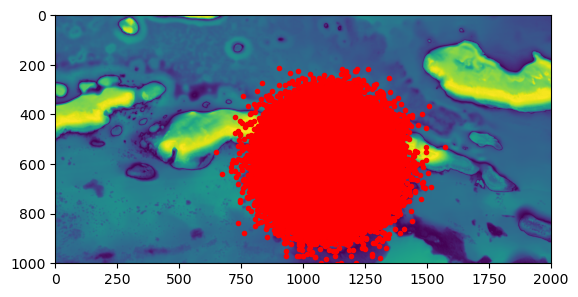

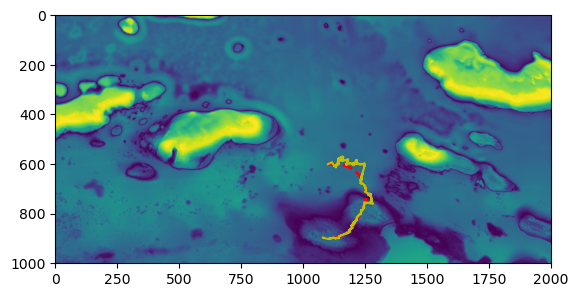

In [32]:
num_trials = 1
# gpu_n_particles_test = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 150000]
gpu_n_particles_test = [100000]


gpu_timing_results = ones(num_trials, size(gpu_n_particles_test)[1])
gpu_error_results = ones(num_trials, size(gpu_n_particles_test)[1])

for (p_idx, n_particles) in enumerate(gpu_n_particles_test)
    for trial_idx in range(1,num_trials)
        bench_result, pf_result, error = bench_pf_gpu(n_particles, init_std_pos, init_std_rot, η, bathy_map, ϵ,
                start_x, start_y, start_θ, sim_time, n_steps, input_func,
                num_evals, num_samples, true);
        gpu_timing_results[trial_idx, p_idx] = bench_result
        gpu_error_results[trial_idx, p_idx] = error
    end
end

In [24]:
# # Save results
# writedlm("timing_gpu_6.txt", gpu_timing_results)
# writedlm("error_gpu_6.txt", gpu_error_results)

## Plotting

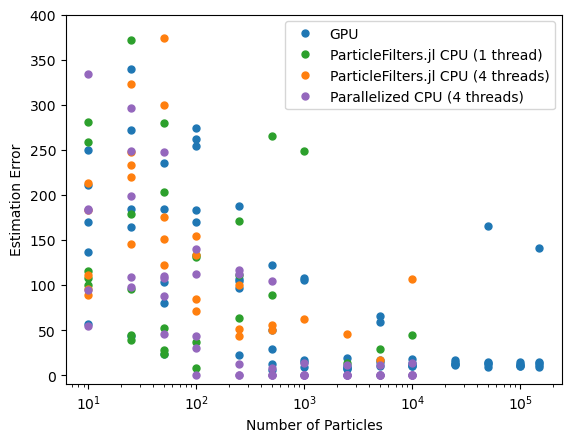

PyObject <matplotlib.legend.Legend object at 0x000001888B37F160>

In [36]:
cpu_n_particles_test = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
gpu_n_particles_test = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 150000]
threaded_n_particles_test = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000]

gpu_error_results = readdlm("benchmarks/error_gpu_5.txt")
cpu_error_results3 = readdlm("benchmarks/error_cpu_3.txt")
cpu_error_results4 = readdlm("benchmarks/error_cpu_4.txt")
threaded_error_results = readdlm("benchmarks/error_threaded_1.txt")

# Make 0's very negative for plotting
idx = findall(gpu_error_results .== 0)
gpu_error_results[idx] .= -500

idx = findall(cpu_error_results3 .== 0)
cpu_error_results3[idx] .= -500

idx = findall(cpu_error_results4 .== 0)
cpu_error_results4[idx] .= -500



fig, ax = PyPlot.subplots()
for r_idx in range(1, size(gpu_error_results)[1])
    if r_idx == 1
        ax.plot(gpu_n_particles_test, gpu_error_results[r_idx, :],".", color="tab:blue", markersize=10, label="GPU")
    else
        ax.plot(gpu_n_particles_test, gpu_error_results[r_idx, :],".", color="tab:blue", markersize=10)
    end
    ax.set_xscale("log")
end

for r_idx in range(1, size(cpu_error_results)[1])
    if r_idx == 1
        ax.plot(cpu_n_particles_test, cpu_error_results3[r_idx, :],".", color="tab:green", markersize=10, label="ParticleFilters.jl CPU (1 thread)")
    else
        ax.plot(cpu_n_particles_test, cpu_error_results3[r_idx, :],".", color="tab:green", markersize=10)
    end
    ax.set_xscale("log")
end

for r_idx in range(1, size(cpu_error_results)[1])
    if r_idx == 1
        ax.plot(cpu_n_particles_test, cpu_error_results4[r_idx, :],".", color="tab:orange", markersize=10, label="ParticleFilters.jl CPU (4 threads)")
    else
        ax.plot(cpu_n_particles_test, cpu_error_results4[r_idx, :],".", color="tab:orange", markersize=10)
    end
    ax.set_xscale("log")
end

for r_idx in range(1, size(threaded_timing_results)[1])
    if r_idx == 1
        ax.plot(threaded_n_particles_test, threaded_error_results[r_idx, :],".", color="tab:purple", markersize=10, label="Parallelized CPU (4 threads)")
    else
        ax.plot(threaded_n_particles_test, threaded_error_results[r_idx, :],".", color="tab:purple", markersize=10)
    end
    ax.set_xscale("log")
end

ax.set_ylabel("Estimation Error")
ax.set_xlabel("Number of Particles")
ax.set_ylim([-10, 400])
ax.legend()
# ax.plot(pf_estimate[:,1], pf_estimate[:,2], "y")


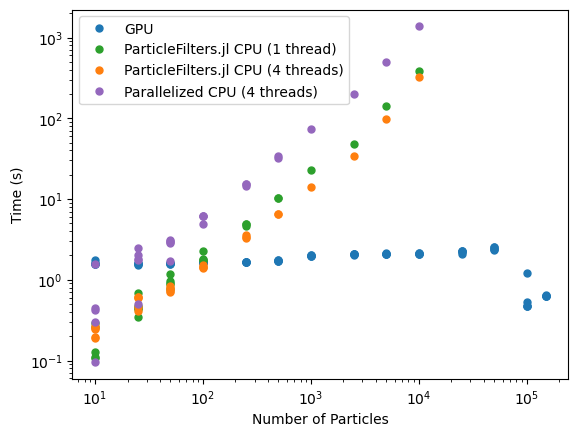

PyObject <matplotlib.legend.Legend object at 0x0000018905A8C610>

In [37]:
gpu_timing_results = readdlm("benchmarks/timing_gpu_5.txt")
cpu_timing_results3 = readdlm("benchmarks/timing_cpu_3.txt")
cpu_timing_results4 = readdlm("benchmarks/timing_cpu_4.txt")
threaded_timing_results = readdlm("benchmarks/timing_threaded_1.txt")

fig, ax = PyPlot.subplots()
for r_idx in range(1, size(gpu_timing_results)[1])
    if r_idx == 1
        ax.plot(gpu_n_particles_test, gpu_timing_results[r_idx, :],".", color="tab:blue", markersize=10, label="GPU")
    else
        ax.plot(gpu_n_particles_test, gpu_timing_results[r_idx, :],".", color="tab:blue", markersize=10)
    end
    ax.set_xscale("log")
end

for r_idx in range(1, size(cpu_timing_results)[1])
    if r_idx == 1
        ax.plot(cpu_n_particles_test, cpu_timing_results3[r_idx, :],".", color="tab:green", markersize=10, label="ParticleFilters.jl CPU (1 thread)")
    else
        ax.plot(cpu_n_particles_test, cpu_timing_results3[r_idx, :],".", color="tab:green", markersize=10)
    end
    ax.set_xscale("log")
    ax.set_yscale("log")
end

for r_idx in range(1, size(cpu_timing_results)[1])
    if r_idx == 1
        ax.plot(cpu_n_particles_test, cpu_timing_results4[r_idx, :],".", color="tab:orange", markersize=10, label="ParticleFilters.jl CPU (4 threads)")
    else
        ax.plot(cpu_n_particles_test, cpu_timing_results4[r_idx, :],".", color="tab:orange", markersize=10)
    end
    ax.set_xscale("log")
    ax.set_yscale("log")
end

for r_idx in range(1, size(threaded_timing_results)[1])
    if r_idx == 1
        ax.plot(threaded_n_particles_test, threaded_timing_results[r_idx, :],".", color="tab:purple", markersize=10, label="Parallelized CPU (4 threads)")
    else
        ax.plot(threaded_n_particles_test, threaded_timing_results[r_idx, :],".", color="tab:purple", markersize=10)
    end
    ax.set_xscale("log")
    ax.set_yscale("log")
end

ax.set_ylabel("Time (s)")
ax.set_xlabel("Number of Particles")
ax.legend()
# ax.plot(pf_estimate[:,1], pf_estimate[:,2], "y")